In [1]:
import numpy as np
import copy
import netCDF4 as nc
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import esmpy as ESMF
from scipy import stats
import xarray as xr
import pyart
import cmocean

Could not save font_manager cache [Errno 28] No space left on device
/nbhome/role.medgrp/.conda/envs/medpy311/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def plot_map(clon,clat,lon,lat,var_val,vmin,vmax,cmap,norm,c_inc):

    ax = fig.add_subplot(spec[nrow,ncol], projection=ccrs.PlateCarree(central_longitude=-100))

    C = ax.pcolormesh(clon,clat,var_val, transform=ccrs.PlateCarree(),
                      cmap=cmap, norm=norm)
                                #vmin=vmin,vmax=vmax,cmap=cmap, norm=norm)
    
    levels = np.arange(vmin,vmax+c_inc/2,c_inc)

    CS = ax.contour(lon,lat,var_val,levels, colors='k', transform=ccrs.PlateCarree())
                            
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',facecolor='blanchedalmond')
    #ax.add_feature(cfeature.LAND,'50m',color='#999999',zorder=50)
    ax.add_feature(land_50m,zorder=50)
    ax.coastlines('50m',zorder=50)
    outline_nep_domain(ax,nep_clon,nep_clat)
            
    # ADDING GRID LINES AND GRID LABELS
    gl = ax.gridlines(draw_labels=True)
    
    gl.xlocator = mticker.FixedLocator([180, -150, -120])
    gl.ylocator = mticker.FixedLocator([25, 55])
    
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}
    gl.bottom_labels = False
    gl.top_labels = False

        
    if ncol>0:
        gl.left_labels = False
        
    if ncol<2:
        gl.right_labels = False
    
    if nrow == 2:
        gl.bottom_labels = True
        
    plt.setp(ax.spines.values(), linewidth=2,zorder=100)
    
    # COLORBARS
    if dep == '200m':
        pos = ax.get_position()
        cbar_x = pos.x0
        
        pos_ref = plt.gcf().axes[6].get_position()
        cbar_h = .1*pos_ref.height
        cbar_y = pos_ref.y0 -.25*pos_ref.height
        print(cbar_y)

        if ncol == 1:
            cax = fig.add_axes([pos_ref.x0, cbar_y, 2*pos.width, cbar_h])
            cbar = plt.colorbar(C,cax=cax,orientation='horizontal',extend='both')
            cbar.ax.set_xticks(levels[::2])
            cax.plot([levels]*2, [0, 1], 'k')
            cbar.ax.tick_params(labelsize=16)
            cax.set_xlabel(('[' + nutrient + '] (' + nutrient_dict[nutrient]['units'] +')'),fontsize=20)
            
        elif ncol == 3:
            cax = fig.add_axes([pos.x0, cbar_y, pos.width, cbar_h])
            cbar = plt.colorbar(C,cax=cax,orientation='horizontal',extend='both')
            cbar.ax.locator_params(nbins=5)
            cax.plot([levels[levels>=0]]*2, [0, 1], 'k')
            cax.plot([levels[levels<0]]*2, [0, 1], '--k')
            cbar.ax.tick_params(labelsize=16)
            cax.set_xlabel(('Difference ' + '(' + nutrient_dict[nutrient]['units'] +')'),fontsize=20)
    # Labels
    if ncol == 0:
        plt_lab = depths_dict[dep]['plt_lab']   
        ax.text(243.0, 56, plt_lab, transform=ccrs.PlateCarree(), fontsize=25, ha='center', zorder=53)
    elif ncol == 3:
        stats_text = 'Bias: ' + f'{mean_bias:.2f}' + '\nRMSE: ' + f'{rmse:.2f}' + '\nMedAE: ' + f'{medae:.2f}' + '\nR: ' + f'{corr[0]:.2f}' 
        ax.text(.03, .05, stats_text, ha="left", va="bottom", size=26, bbox=stats_box_props,transform=ax.transAxes)
# Titles
    if (nrow == 0) or (nrow == 4):
        if ncol == 0:
            title_text = 'NEP10k'
        elif ncol == 1:
            title_text = 'WOA23'
        else:
            title_text = 'NEP10k - WOA23'
        
        ax.set_title(title_text, fontsize=28)
        
    ax.text(160,65, plot_labels[nlab], fontsize=25, ha='center', va='center',
            transform=ccrs.PlateCarree(),zorder=55)          
    # SET AXES EXTENT
    ax.set_extent([np.min(nep_clon),np.max(nep_clon),
                   np.min(nep_clat),70], crs=ccrs.PlateCarree())    
    plt.draw()


In [3]:
def get_model_ds(src_model):
    
    # CONSTRUCT FILE NAME
    ncfil = (mod_dict[src_model]['dir'] + mod_dict[src_model]['fil_pre'] 
             + '_' + nutrient_dict[nutrient][src_model]['fil_str'] 
             + season_dict[season][src_model] + mod_dict[src_model]['fil_suf']  + '.nc')
            
    print(ncfil)
            
    # Open as xarray dataset
    ds = xr.open_dataset((ncfil),decode_times=False)
            
    if src_model == 'NEP':
        ds = ds.rename({'z_l':'depth'})
        
    return ds

In [4]:
def get_coords(src_model,ds):
 
    if src_model == 'WOA':
        lat = ds.lat.values
        lon = ds.lon.values
        clat = np.append(ds.lat_bnds.values[:,0],ds.lat_bnds.values[-1,-1])
        clon = np.append(ds.lon_bnds.values[:,0],ds.lon_bnds.values[-1,-1])

    elif src_model == 'NEP':
 
        lon = nep_lon
        lat = nep_lat
        clon = nep_clon 
        clat = nep_clat
        
    lons,lats = np.meshgrid(lon,lat)
    chuk_mask = lats>66
    return lat,lon,clat,clon,chuk_mask

In [5]:
def calc_stats(nep_val_stats, comp_val_stats, area_val):
    # CALCULATE STATISTICS
    nan_idx = ~np.isnan(nep_val_stats)*~np.isnan(comp_val_stats)
    
    # Mean Bias
    mean_bias = np.nanmean((nep_val_stats-comp_val_stats)[nan_idx])
    if print_stats:
        print('MEAN BIAS:', mean_bias)

    # Mean Bias Area Weighted
    mean_bias = np.nansum(((nep_val_stats*area_val)[nan_idx]-(comp_val_stats*area_val)[nan_idx])/np.nansum(area_val[nan_idx]))
    if print_stats:
        print('AREA-WEIGHTED MEAN BIAS:', mean_bias)

    # RMSE 
    rmse = np.sqrt(np.mean(((nep_val_stats-comp_val_stats)**2)[nan_idx]))
    if print_stats:
        print('RMSE:', rmse)

    # RMSE Area weighted
    rmse = np.sqrt(np.sum((((nep_val_stats-comp_val_stats)**2)*area_val)[nan_idx]/np.sum(area_val[nan_idx])))
    if print_stats:
        print('AREA-WEIGHTED RMSE:', rmse)
        
    # Median absolute error
    medae = np.nanmedian(np.abs(nep_val_stats-comp_val_stats)[nan_idx])
    if print_stats:
        print('MEDIAN ABSOLUTE ERROR:', medae)

    # Correlation
    corr = stats.pearsonr(nep_val_stats[nan_idx].ravel(), comp_val_stats[nan_idx].ravel())
    if print_stats:
        print('CORRELATION:', corr)
    
    return mean_bias, rmse, medae, corr

In [6]:
def create_regrid_obj(src_clon,src_clat,src_lsm,dst_clon,dst_clat):
    # Make 2D coordinates for remapping
    if len(src_clon.shape)<2:
        src_clon,src_clat = np.meshgrid(src_clon,src_clat)
        
    if len(dst_clon.shape)<2:
        dst_clon,dst_clat = np.meshgrid(dst_clon,dst_clat)
    
    sourcegrid = ESMF.Grid(np.array(src_lsm.shape), staggerloc = ESMF.StaggerLoc.CORNER,coord_sys = ESMF.CoordSys.SPH_DEG)
    sourcegrid.add_item(ESMF.GridItem.MASK,[ESMF.StaggerLoc.CENTER])
    grid_mask = sourcegrid.get_item(ESMF.GridItem.MASK)
    grid_mask[...] = src_lsm.astype(np.int32) 

    source_lon = sourcegrid.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)
    source_lat = sourcegrid.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)

    source_lon[...] = src_clon
    source_lat[...] = src_clat

    sourcefield = ESMF.Field(sourcegrid, name = 'src_field')
    srcfracfield = ESMF.Field(sourcegrid, 'srcfracfield')
        
    destgrid = ESMF.Grid(np.array(dst_clon[1:,1:].shape), staggerloc = ESMF.StaggerLoc.CORNER, coord_sys = ESMF.CoordSys.SPH_DEG)

    dest_clon = destgrid.get_coords(0,staggerloc=ESMF.StaggerLoc.CORNER)
    dest_clat = destgrid.get_coords(1,staggerloc=ESMF.StaggerLoc.CORNER)

    dest_clon[...] = dst_clon
    dest_clat[...] = dst_clat

    destfield = ESMF.Field(destgrid, name = 'dest_field')

    # DEFINE INTERPOLATION FUNCTION
    regrid = ESMF.Regrid(sourcefield, destfield,regrid_method = ESMF.RegridMethod.CONSERVE,
                     src_mask_values=np.array([0], dtype=np.int32),src_frac_field=srcfracfield,
                     norm_type=ESMF.NormType.FRACAREA,unmapped_action = ESMF.UnmappedAction.IGNORE)

    return sourcefield, destfield, regrid

In [7]:
def outline_nep_domain(ax,clon,clat):
    #NEP DOMAIN OUTLINE
    ax.plot(clon[0,:],clat[0,:],linewidth=1.5,color='k',transform=ccrs.PlateCarree(),zorder=42)
    ax.plot(clon[:,0],clat[:,0],linewidth=1.5,color='k',transform=ccrs.PlateCarree(),zorder=42)
    ax.plot(clon[-1,:],clat[-1,:],linewidth=1.5,color='k',transform=ccrs.PlateCarree(),zorder=42)
    ax.plot(clon[:,-1],clat[:,-1],linewidth=1.5,color='k',transform=ccrs.PlateCarree(),zorder=42)

In [8]:
mod_dict = {'NEP':{'dir':'/work/role.medgrp/NEP/plotting/Figure_7_8_12/',
                   'fil_pre':'nep',
                   'fil_suf':'_ts',},
            'WOA':{'dir':'/work/role.medgrp/NEP/plotting/Figure_7_8_12/',
                   'fil_pre':'woa23_all',
                   'fil_suf':'_01',
                   'plt_title':'Regional Dataset'},}

# DEPTHS
depths_dict = {'surface': {'val':2.5, 'plt_lab':'Surface'}, 
               '100m':    {'val':100, 'plt_lab':'100m'},
               '200m':    {'val':200, 'plt_lab':'200m'}}

nutrient_dict = {'Nitrate':{'NEP':{'fil_str':'no3_', 'var_nm':'no3','k':1000000},
                            'WOA':{'fil_str':'n', 'var_nm':'n_an','k':1}, 
                            'units':r'$\mu$mol kg$^{-1}$',
                            'vmin':0,'vmax':40,'cbar_n':17, 'inc':5, 
                            'dif_range':6, 'dif_cbar_n':25, 'dif_inc':1.5,'figure_lab':7},
                 'Oxygen':{'NEP':{'fil_str':'o2_','var_nm':'o2','k':1000000},
                              'WOA':{'fil_str':'o', 'var_nm':'o_an','k':1},
                              'units':r'$\mu$mol kg$^{-1}$',
                              'vmin':0,'vmax':350,'cbar_n':17, 'inc':25, 
                              'dif_range':50, 'dif_cbar_n':29, 'dif_inc':25,'figure_lab':12},
                 'Phosphate':{'NEP':{'fil_str':'po4_','var_nm':'po4','k':1000000},
                              'WOA':{'fil_str':'p', 'var_nm':'p_an','k':1},
                              'units':r'$\mu$mol kg$^{-1}$',
                              'vmin':0,'vmax':3,'cbar_n':17, 'inc':.25, 
                              'dif_range':1, 'dif_cbar_n':25, 'dif_inc':.25,'figure_lab':8},}

season_dict = {'mean':   {'NEP':'1993-2019_mean', 'WOA': '00'},
               'Winter': {'NEP':'1993-2019_JFM',  'WOA': '13'},
               'Spring': {'NEP':'1993-2019_AMJ',  'WOA': '14'},
               'Summer': {'NEP':'1993-2019_JAS',  'WOA': '15'},
               'Fall':   {'NEP':'1993-2019_OND',  'WOA': '16'},}

cmap1 = 'pyart_HomeyerRainbow'
bounds = np.linspace(32,35,25)
norm1 = mcolors.BoundaryNorm(bounds, 256, extend='both')

cmap2 = cmocean.cm.balance
bounds = np.linspace(-1,1,17)
norm2 = mcolors.BoundaryNorm(bounds, cmap2.N, extend='both')
plot_labels = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r']

In [9]:
# NEP Grid
nep_grd_fil = '/work/role.medgrp/NEP/plotting/shared_files/NEP_ocean_static_nomask.nc'
grd_fid = nc.Dataset(nep_grd_fil)

# Extracting tracer lat/lon from the supergrid
nep_lat = grd_fid.variables['geolat'][:]
nep_lon = grd_fid.variables['geolon'][:]

# Extracting tracer corner lat/lon from the supergrid - needed for regridding and pcolor plots
nep_clat = grd_fid.variables['geolat_c'][:]
nep_clon = grd_fid.variables['geolon_c'][:]

nep_topo = grd_fid.variables['deptho'][:]

lsm = grd_fid.variables['wet'][:]
lsm[lsm<1]=0 
lsm[lsm>1]=1 

nep_area = grd_fid.variables['areacello'][:].squeeze()
nep_area[lsm<.5]=0

/work/role.medgrp/NEP/plotting/Figure_7_8_12/nep_no3_1993-2019_mean_ts.nc
/work/role.medgrp/NEP/plotting/Figure_7_8_12/woa23_all_n00_01.nc
surface
MEAN BIAS: 0.7376914996736051
AREA-WEIGHTED MEAN BIAS: 0.7701670325037846
RMSE: 2.1682087836279913
AREA-WEIGHTED RMSE: 2.222818753991313
MEDIAN ABSOLUTE ERROR: 0.6809286803269613
CORRELATION: PearsonRResult(statistic=0.9620623239794072, pvalue=0.0)
100m
MEAN BIAS: 0.7898949063870173
AREA-WEIGHTED MEAN BIAS: 0.8712388645135853
RMSE: 2.0161620550019705
AREA-WEIGHTED RMSE: 2.0334369067015303
MEDIAN ABSOLUTE ERROR: 1.2730821586112038
CORRELATION: PearsonRResult(statistic=0.9813311448040268, pvalue=0.0)
200m
0.09796874999999995
0.11012347858564261
MEAN BIAS: -0.5321503953963249
AREA-WEIGHTED MEAN BIAS: -0.49035657990387294
RMSE: 2.1195035866646283
AREA-WEIGHTED RMSE: 2.1369961535958515
MEDIAN ABSOLUTE ERROR: 1.470248836078781
CORRELATION: PearsonRResult(statistic=0.9789799481697186, pvalue=0.0)
0.11012347858564261
/work/role.medgrp/NEP/plotting/F

FileNotFoundError: [Errno 2] No such file or directory: '/work/role.medgrp/NEP/plotting/Figure_7_8_12/woa23_all_p00_01.nc'

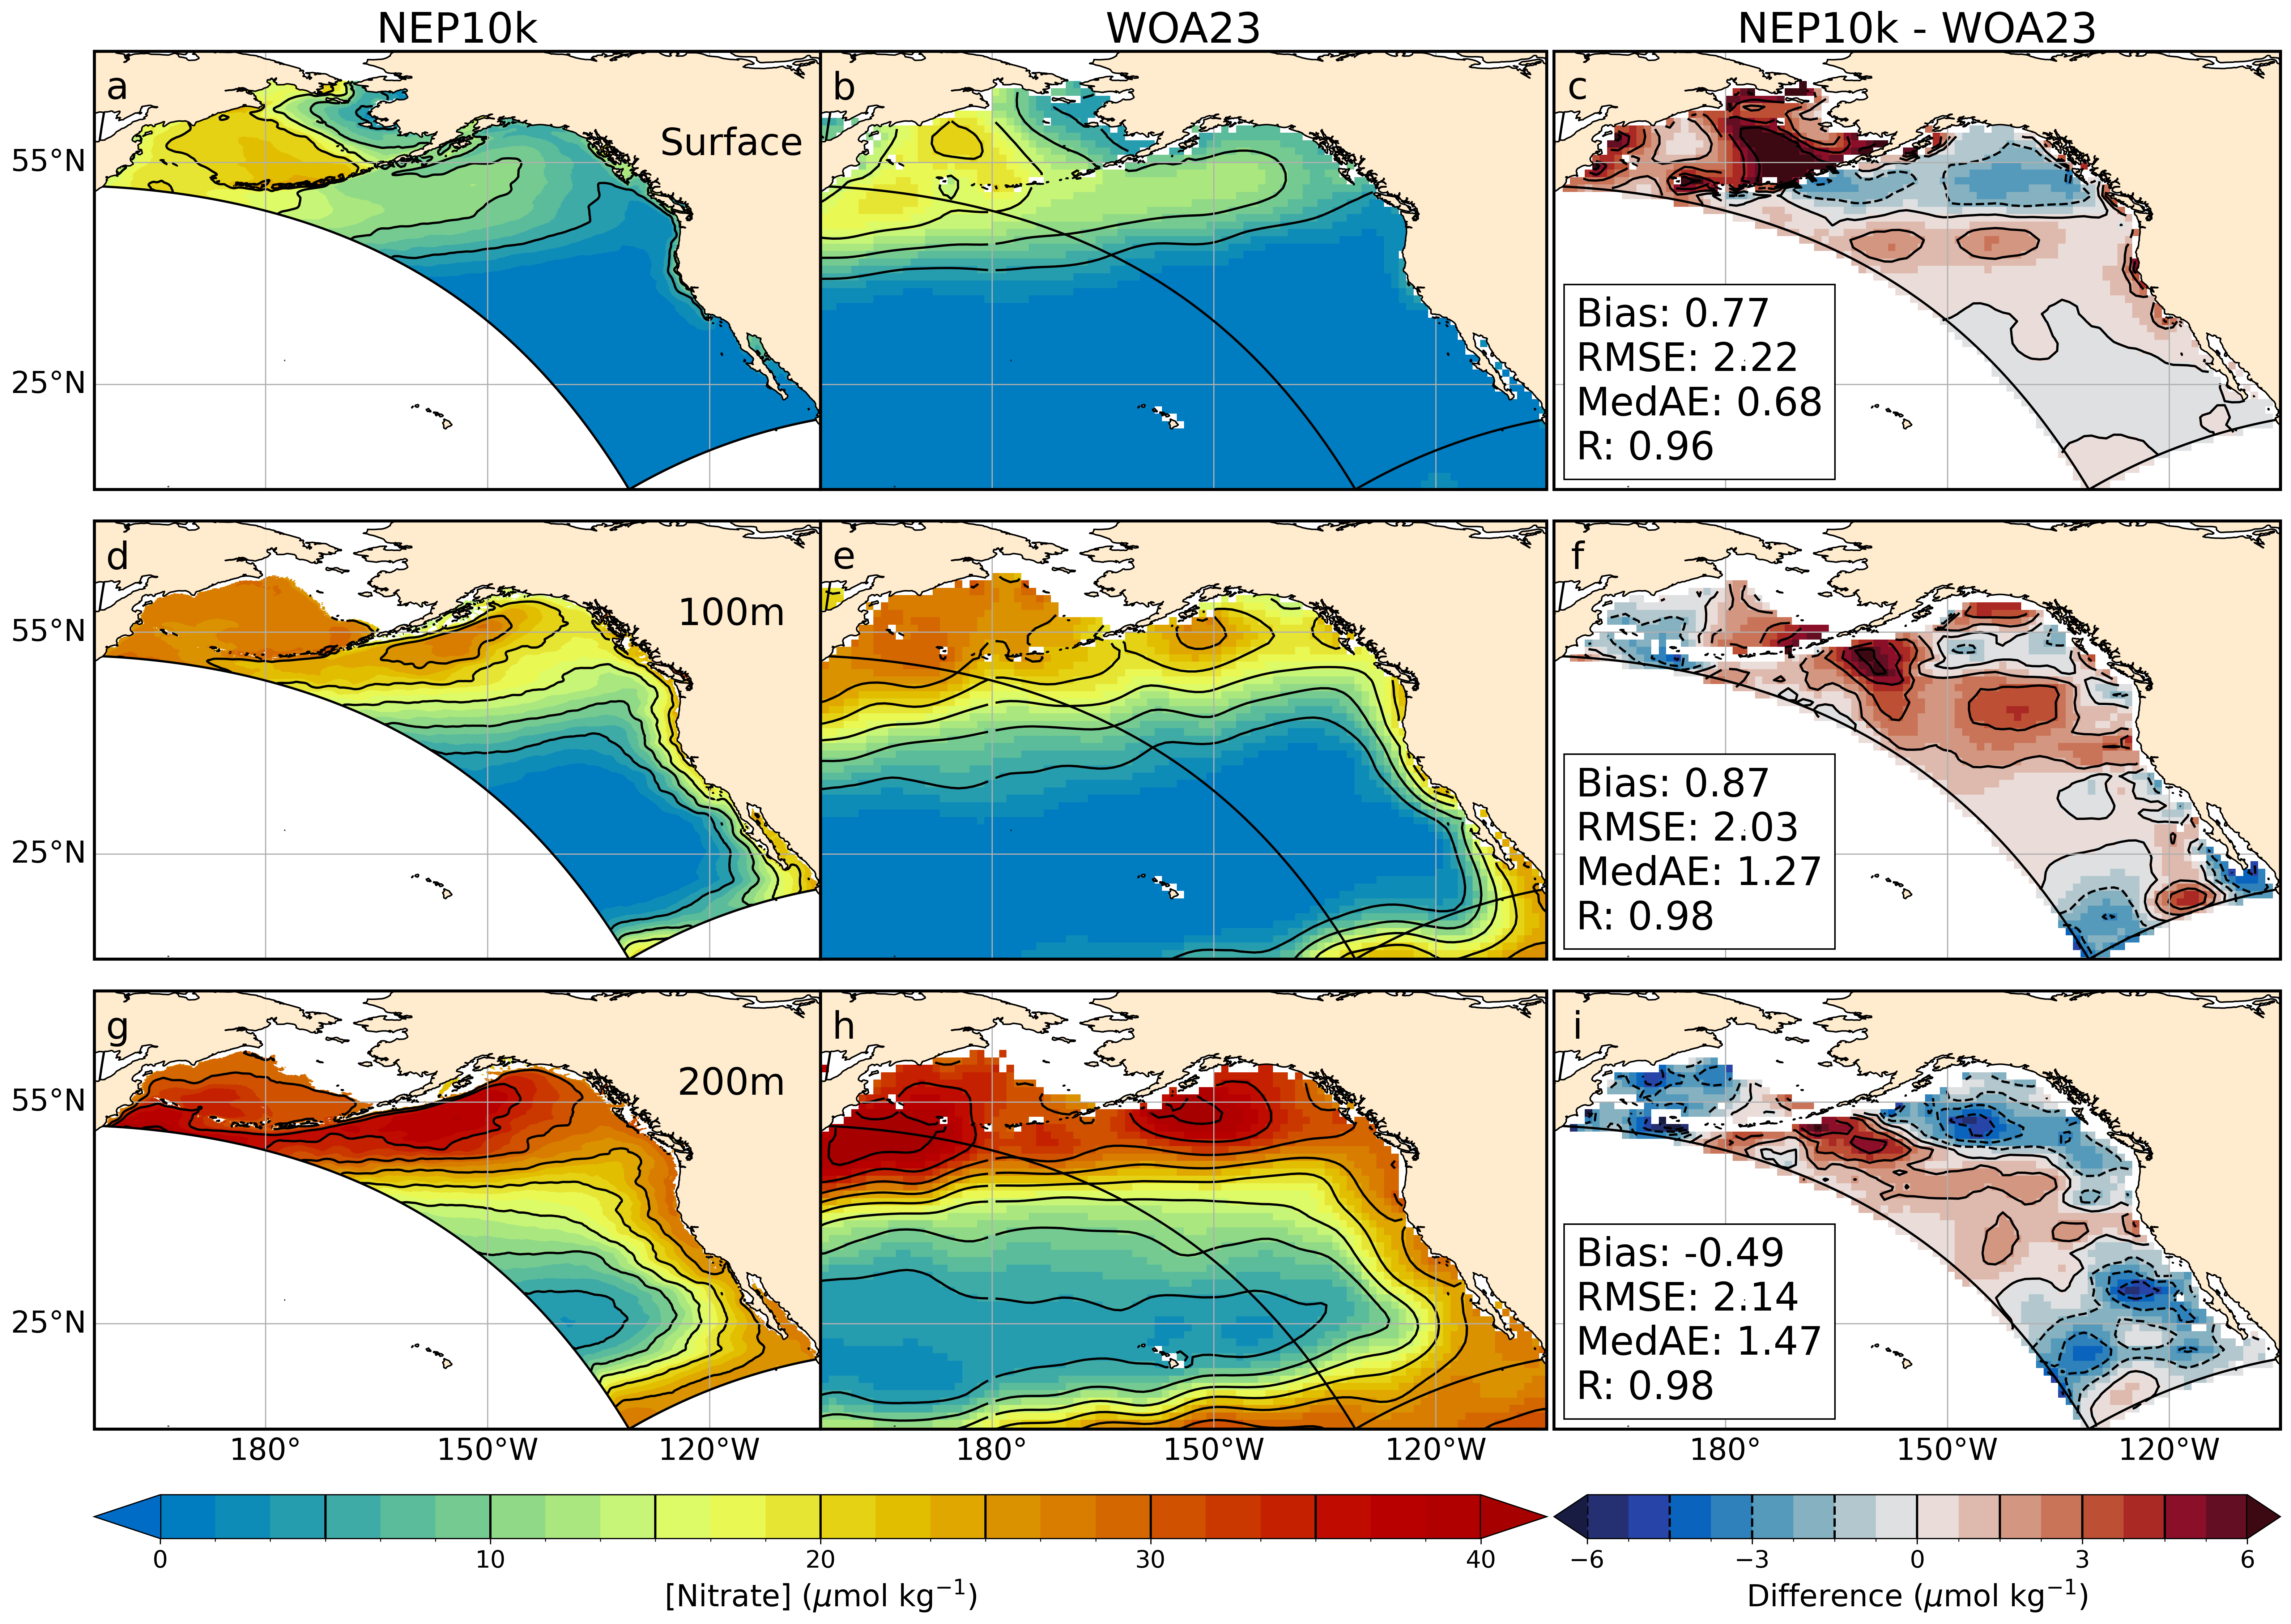

<Figure size 7800x5400 with 0 Axes>

In [10]:
print_stats=True
const_offset = 500
heights = [10,10,10,2]
widths = [10,10,.1,10]
stats_box_props = dict(boxstyle="square", fc="w", ec="0.0", alpha=1)         

for nutrient in ['Nitrate','Phosphate','Oxygen']:
    # Colorbars
    cmap2 = cmocean.cm.balance
    bounds = np.linspace(-nutrient_dict[nutrient]['dif_range'],
                         nutrient_dict[nutrient]['dif_range'],
                         nutrient_dict[nutrient]['cbar_n'])

    norm2 = mcolors.BoundaryNorm(bounds, cmap2.N, extend='both')

    cmap1 = 'pyart_HomeyerRainbow'
    bounds = np.linspace(nutrient_dict[nutrient]['vmin'],
                         nutrient_dict[nutrient]['vmax'],
                         nutrient_dict[nutrient]['dif_cbar_n'])

    norm1 = mcolors.BoundaryNorm(bounds, 256, extend='both')
    
    for season in ['mean']:
        fig = plt.figure(figsize=(26,18),dpi=300)
        spec = fig.add_gridspec(ncols=4, nrows=4,wspace=0,hspace=0.,height_ratios=heights, width_ratios=widths)  
        nrow = 0
        nlab = 0
    
        ds_NEP = get_model_ds('NEP')
        ds_comp = get_model_ds('WOA')  
        lat,lon,clat,clon,chuk_mask = get_coords('WOA',ds_comp)
        sourcefield, destfield, regrid = create_regrid_obj(nep_clon,nep_clat,lsm,clon,clat)
        for dep,nrow in zip(depths_dict,range(len(depths_dict))):
            ncol=0
            print(dep)

            # Interpolate depth values 
            comp_val = nutrient_dict[nutrient]['WOA']['k']*ds_comp[nutrient_dict[nutrient]['WOA']['var_nm']].interp(depth=depths_dict[dep]['val']).values.squeeze()
            nep_val = nutrient_dict[nutrient]['NEP']['k']*ds_NEP[nutrient_dict[nutrient]['NEP']['var_nm']].interp(depth=depths_dict[dep]['val']).values.squeeze()
            nep_val[:,nep_topo<=depths_dict[dep]['val']] = np.nan
            
            nt1 = len(nep_val)               
            nj,ni = comp_val.shape
                
            nep_val_out = np.zeros((nt1,nj,ni)) 
            conts_offset = np.nanmax(nep_val_out)+10
            for nt in range(nt1):
                sourcefield.data[...] = nep_val[nt,:].squeeze() + const_offset
                destfield = regrid(sourcefield, destfield)
                tmp_val = copy.deepcopy(destfield.data)
                tmp_val[tmp_val==0] = np.nan
                nep_val_out[nt,:] = tmp_val - const_offset  
           
            sourcefield.data[...] = lsm + const_offset
            destfield = regrid(sourcefield, destfield)
            tmp_val = copy.deepcopy(destfield.data)
            tmp_val[tmp_val==0] = np.nan
            lsm_out = tmp_val - const_offset
            lsm_out[lsm_out>.5]=1
            lsm_out[lsm_out<.5]=0
            
            comp_diff_val = copy.deepcopy(comp_val)
            # remove chukchi sea
            comp_diff_val[chuk_mask] = np.nan
            # remove values outside NEP domain
            comp_diff_val[lsm_out==0] = np.nan
            
            nep_diff_val = copy.deepcopy(nep_val_out)
            nep_diff_val = np.mean(nep_diff_val,axis=0)
            # remove chukchi sea
            nep_diff_val[chuk_mask] = np.nan
            # remove values outside NEP domain
            nep_diff_val[lsm_out==0] = np.nan
            
            # Get area for weighted statistics 
            sourcefield.data[...] = nep_area + const_offset
            destfield = regrid(sourcefield, destfield)
            tmp_val = copy.deepcopy(destfield.data)
            tmp_val[tmp_val==0] = np.nan
            area_out = tmp_val - const_offset
            dif_clon = clon; dif_clat = clat
            dif_lon = lon; dif_lat = lat

            
            # Add subplot map to figure
            nep_val[:,nep_lat>66]=np.nan
            plot_map(nep_clon,nep_clat,nep_lon,nep_lat,np.mean(nep_val,axis=0),
                     nutrient_dict[nutrient]['vmin'],nutrient_dict[nutrient]['vmax'],
                     cmap1,norm1,nutrient_dict[nutrient]['inc'])
            
            ncol+=1
            nlab+=1
            
            comp_val[chuk_mask]=np.nan
            plot_map(clon,clat,lon,lat,comp_val,
                     nutrient_dict[nutrient]['vmin'],nutrient_dict[nutrient]['vmax'],
                     cmap1,norm1,nutrient_dict[nutrient]['inc'])
            ncol+=2
            nlab+=1

            # CALCULATE STATISTICS
            mean_bias, rmse, medae, corr = calc_stats(nep_diff_val,comp_diff_val,area_out)
            
            plot_map(dif_clon,dif_clat,dif_lon,dif_lat,nep_diff_val-comp_diff_val,
                     -nutrient_dict[nutrient]['dif_range'],nutrient_dict[nutrient]['dif_range'],
                     cmap2,norm2,nutrient_dict[nutrient]['dif_inc'])
            
            nlab+=1
                
        
        fig_file_name = 'Figure' + str(nutrient_dict[nutrient]['figure_lab'])+ '_' + nutrient + '_NEP_vs_WOA23_mean'

        plt.savefig(fig_file_name)
            